In [26]:
# libraries needed for the project - if you don't have any of them, install them using pip install <library name>

import pandas as pd
import numpy as np
import os
from PIL import Image
import csv
import matplotlib.pyplot as plt # for plotting the images


# libraries for the supervised deep learning classification model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [6]:

# Define constants
folder_path = "../question_01/dataset"
img_width, img_height = 150, 150
batch_size = 16
epochs = 50


In [7]:
# Prepare data
file_names = os.listdir(folder_path)

# get the images with the specific label "real" or "fake"
real_files = [file for file in file_names if "real" in file]
fake_files = [file for file in file_names if "fake" in file]

# Split the data into training and testing
real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)
fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)

# Combine the real and fake images into one list
train_files = real_train + fake_train
test_files = real_test + fake_test

# Create labels for the training and testing data
train_labels = ['real'] * len(real_train) + ['fake'] * len(fake_train)
test_labels = ['real'] * len(real_test) + ['fake'] * len(fake_test)

# Convert labels to categorical values ('real' -> 0, 'fake' -> 1)
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)


In [8]:
print("Number of training images: ", len(train_files))
print("Number of testing images: ", len(test_files))

Number of training images:  120
Number of testing images:  30


In [31]:
def data_generator(files, labels, batch_size):
    """
    Generator function that yields batches of data for training or validation.

    Args:
        files (list): List of file paths/indices for the batch.
        labels (list): List of labels corresponding to the files.
        batch_size (int): Number of samples per batch.

    Yields:
        tuple: A tuple of batch input data and corresponding labels.

    """

    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a=files, size=batch_size)
        batch_input = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels 
        for input_path in batch_paths:
            input = load_img(os.path.join(folder_path, input_path), target_size=(224, 224))  # adjusted here
            input = img_to_array(input)
            output = labels[files.index(input_path)]

            batch_input.append(input)
            batch_output.append(output)
        # Return a tuple of (input, output) to feed the network 
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output).reshape(-1, 1)  # Reshape labels to (batch_size, 1) for use in categorical_crossentropy loss

        yield(batch_x, batch_y)


In [32]:
# using ImageDataGenerator for augmentation and rescaling (normalization) of the data 
datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = data_generator(train_files, train_labels, batch_size)
validation_generator = data_generator(test_files, test_labels, batch_size)

# Define the model architecture (ResNet50)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use 1 neuron for binary classification

# compile the model using Adam's default learning rate
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train te model on the augmented data
model.fit(
    train_generator,
    steps_per_epoch=len(train_files) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(test_files) // batch_size
)

# evaluate the model on the test set
loss, accuracy = model.evaluate(validation_generator, steps=len(test_files) // batch_size)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Epoch 1/50
7/7 [==============================] - 4s 525ms/step - loss: 1516.3408 - accuracy: 0.5179 - val_loss: 69.7577 - val_accuracy: 0.3750
Epoch 2/50
7/7 [==============================] - 3s 501ms/step - loss: 21.6328 - accuracy: 0.4821 - val_loss: 2.0757 - val_accuracy: 0.5625
Epoch 3/50
7/7 [==============================] - 3s 489ms/step - loss: 0.7366 - accuracy: 0.6875 - val_loss: 0.7266 - val_accuracy: 0.3125
Epoch 4/50
7/7 [==============================] - 3s 503ms/step - loss: 0.4115 - accuracy: 0.8839 - val_loss: 0.7538 - val_accuracy: 0.4375
Epoch 5/50
7/7 [==============================] - 3s 493ms/step - loss: 0.2765 - accuracy: 0.8929 - val_loss: 0.8762 - val_accuracy: 0.5000
Epoch 6/50
7/7 [==============================] - 3s 481ms/step - loss: 0.1921 - accuracy: 0.9554 - val_loss: 0.7194 - val_accuracy: 0.6250
Epoch 7/50
7/7 [==============================] - 3s 504ms/step - loss: 0.0831 - accuracy: 0.9732 - val_loss: 0.6615 - val_accuracy: 0.7500
Epoch 8/50
7/7 

In [33]:
# we are going to use the model to predict the labels of the test set

predictions = model.predict(validation_generator, steps=len(test_files) // batch_size)


1/1 [==============================] - 0s 114ms/step


In [34]:
# save the model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'


In [35]:
from tensorflow.keras.models import load_model
model = load_model('my_model.h5')


In [36]:
# Define the path to the test images provided from RD takehome 
test_folder = '../rd_test_dataset/rd_test_dataset'

# print(os.listdir(test_folder))

In [37]:

# Load the model
model = load_model('my_model.h5')
# Define the path to the test images
test_folder = '..\\rd_test_dataset\\rd_test_dataset'

# get a list of all the image filenames
image_filenames = [filename for filename in os.listdir(test_folder) if filename.startswith("0") and (filename.endswith(".jpg") or filename.endswith(".png"))]

# Initialize a list to store the images
images = []

# Load each image, preprocess it, and add it to the list
for image_filename in image_filenames:
    # Load the image
    image = load_img(os.path.join(test_folder, image_filename), target_size=(224, 224))
    
    # Convert the image to a numpy array and preprocess it
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # Add the image to the list
    images.append(image)

# Convert the list to a numpy array
images = np.array(images)
# Use the model to make predictions
predictions = model.predict(images)



1/1 [==============================] - 0s 139ms/step


In [38]:
# convert probabilities to class labels
threshold = 0.5
predicted_labels = ['real' if pred < threshold else 'fake' for pred in predictions]

# Print the predicted labels
for image_filename, predicted_label in zip(image_filenames, predicted_labels):
    print(f"Image: {image_filename}, Predicted Label: {predicted_label}")



Image: 001.jpg, Predicted Label: fake
Image: 002.jpg, Predicted Label: fake
Image: 003.jpg, Predicted Label: fake
Image: 004.jpg, Predicted Label: fake
Image: 005.jpg, Predicted Label: fake
Image: 006.jpg, Predicted Label: fake
Image: 007.jpg, Predicted Label: fake
Image: 008.png, Predicted Label: fake
Image: 009.jpg, Predicted Label: fake
Image: 010.jpg, Predicted Label: fake
Image: 011.png, Predicted Label: fake
Image: 012.jpg, Predicted Label: fake
Image: 013.jpg, Predicted Label: fake
Image: 014.jpg, Predicted Label: fake
Image: 015.jpg, Predicted Label: fake
Image: 016.jpg, Predicted Label: fake
Image: 017.jpg, Predicted Label: fake
Image: 018.jpg, Predicted Label: fake
Image: 019.jpg, Predicted Label: fake
Image: 020.jpg, Predicted Label: fake
Image: 021.jpg, Predicted Label: fake
Image: 022.jpg, Predicted Label: fake


In [29]:
# creating a list of tuples containing image filenames and predicted labels
data = list(zip(image_filenames, predicted_labels))

# Define the output CSV file path and write the data to the CSV file
output_file = 'predictions.csv'
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Prediction'])  # Write the header
    writer.writerows(data)  # Write the image filenames and predictions

print(f"Predictions saved to {output_file} successfully.")




Predictions saved to predictions.csv successfully.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


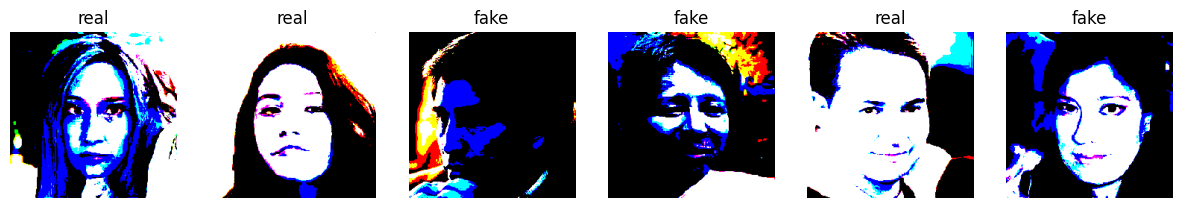

In [30]:
# select a few sample images and their predictions
sample_images = images[:6]
sample_predictions = predicted_labels[:6]

# Visualize the sample images and their predictions
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

for ax, image, prediction in zip(axes, sample_images, sample_predictions):
    ax.imshow(image)
    ax.set_title(prediction)
    ax.axis("off")

plt.show()
